In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import sys
import glob
import math
import os
MAX_MATCHES=30000
sys.setrecursionlimit(20000)


In [10]:
img_dir = r"C:\Users\bedab\OneDrive\AAU\TeeJet-Project\Stitching\m2" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
list_of_lists_of_images = []
for f1 in files:
    img1 = cv2.imread(f1)
    cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    data.append(img1)

w = 3
t = len(data)

for i in range(0, t//w):
    row = data[i*w:(i+1)*w]
    list_of_lists_of_images.append(row)

if t%w != 0:
    i=i+1
    row = data[i*w:-1]
    list_of_lists_of_images.append(row)
    


In [11]:
def find_homography(img1, img2, MIN_MATCH_COUNT = 4):
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    
    sift=cv2.xfeatures2d.SIFT_create(15000)
    brisk=cv2.BRISK_create(60)
    orb = cv2.ORB_create(MAX_MATCHES)
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    print(len(keypoints1))
    print(len(keypoints2))
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(descriptors1,descriptors2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    print(len(good))
        
    #matches = sorted(matches, key = lambda x:x.distance)
    #good=matches[0:1000]

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)    
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

    return M

In [12]:
def putImagesTogether(img1, img2, M):
   # M[0,2] = M[0,2] + img1.shape[1]
    #M[1,2] = M[1,2] + img1.shape[0]
    
    offset=np.array([[1, 0, img1.shape[1]],[0,1,img1.shape[0]],[0,0,1]])
    M=np.matmul(offset,M)
    dst = cv2.warpPerspective(img1,M,(img1.shape[1]*3, img1.shape[0]*3))
    dst[img2.shape[0]:img2.shape[0]*2,img2.shape[1]:img2.shape[1]*2,:] = img2
    
    return dst

def multiple(list_of_lists_of_images, homographys,connections, og_coordinate):
    offset_y=og_coordinate[0]*list_of_lists_of_images[0][0].shape[0]
    offset_x=og_coordinate[0]*list_of_lists_of_images[0][0].shape[1]
    w=list_of_lists_of_images[0][0].shape[1]
    h=list_of_lists_of_images[0][0].shape[0]
    offset=np.array([[1, 0, offset_x],[0,1,offset_y],[0,0,1]])
    
    result=np.zeros(((len(list_of_lists_of_images)*h),len(list_of_lists_of_images[0])*w,3),dtype='uint8')
    for i in range(0,len(homographys)):
        if connections[i][1]==og_coordinate:
            M=np.matmul(offset,homographys[i])
            print(result.shape)
            warped_image = cv2.warpPerspective(list_of_lists_of_images[connections[i][0][0]][connections[i][0][1]],M,(result.shape[1], result.shape[0]))
            print(warped_image.shape)
            result[warped_image!=0]=warped_image[warped_image!=0]
        result[offset_y:offset_y+h,offset_x:offset_x+w,:] =list_of_lists_of_images[og_coordinate[1]][og_coordinate[0]]    
        
            
            
    return result
    

In [13]:
homographys=[find_homography(list_of_lists_of_images[0][1],list_of_lists_of_images[1][1]),find_homography(list_of_lists_of_images[2][1],list_of_lists_of_images[1][1])]
print(homographys)
connections=[((0,1),(1,1)),((2,1),(1,1))]
og_coordinate=(1,1)
res=multiple(list_of_lists_of_images,homographys,connections,og_coordinate)

15000
15001
1815
15000
15001
951
[array([[ 9.91598269e-01,  9.91517895e-02, -8.91192988e+01],
       [-1.27716951e-01,  9.82209655e-01,  8.18096944e+02],
       [ 3.15477033e-06, -1.57545653e-05,  1.00000000e+00]]), array([[ 1.01005920e+00,  3.16746316e-02, -7.25101837e+01],
       [ 3.53038157e-04,  9.92106885e-01, -6.08485441e+02],
       [ 2.49190412e-06,  1.27016331e-05,  1.00000000e+00]])]
(8928, 11904, 3)
(8928, 11904, 3)
(8928, 11904, 3)
(8928, 11904, 3)


In [14]:
fig=plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')  
cv2.imwrite('res.jpg',res)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

15001
15001
15001


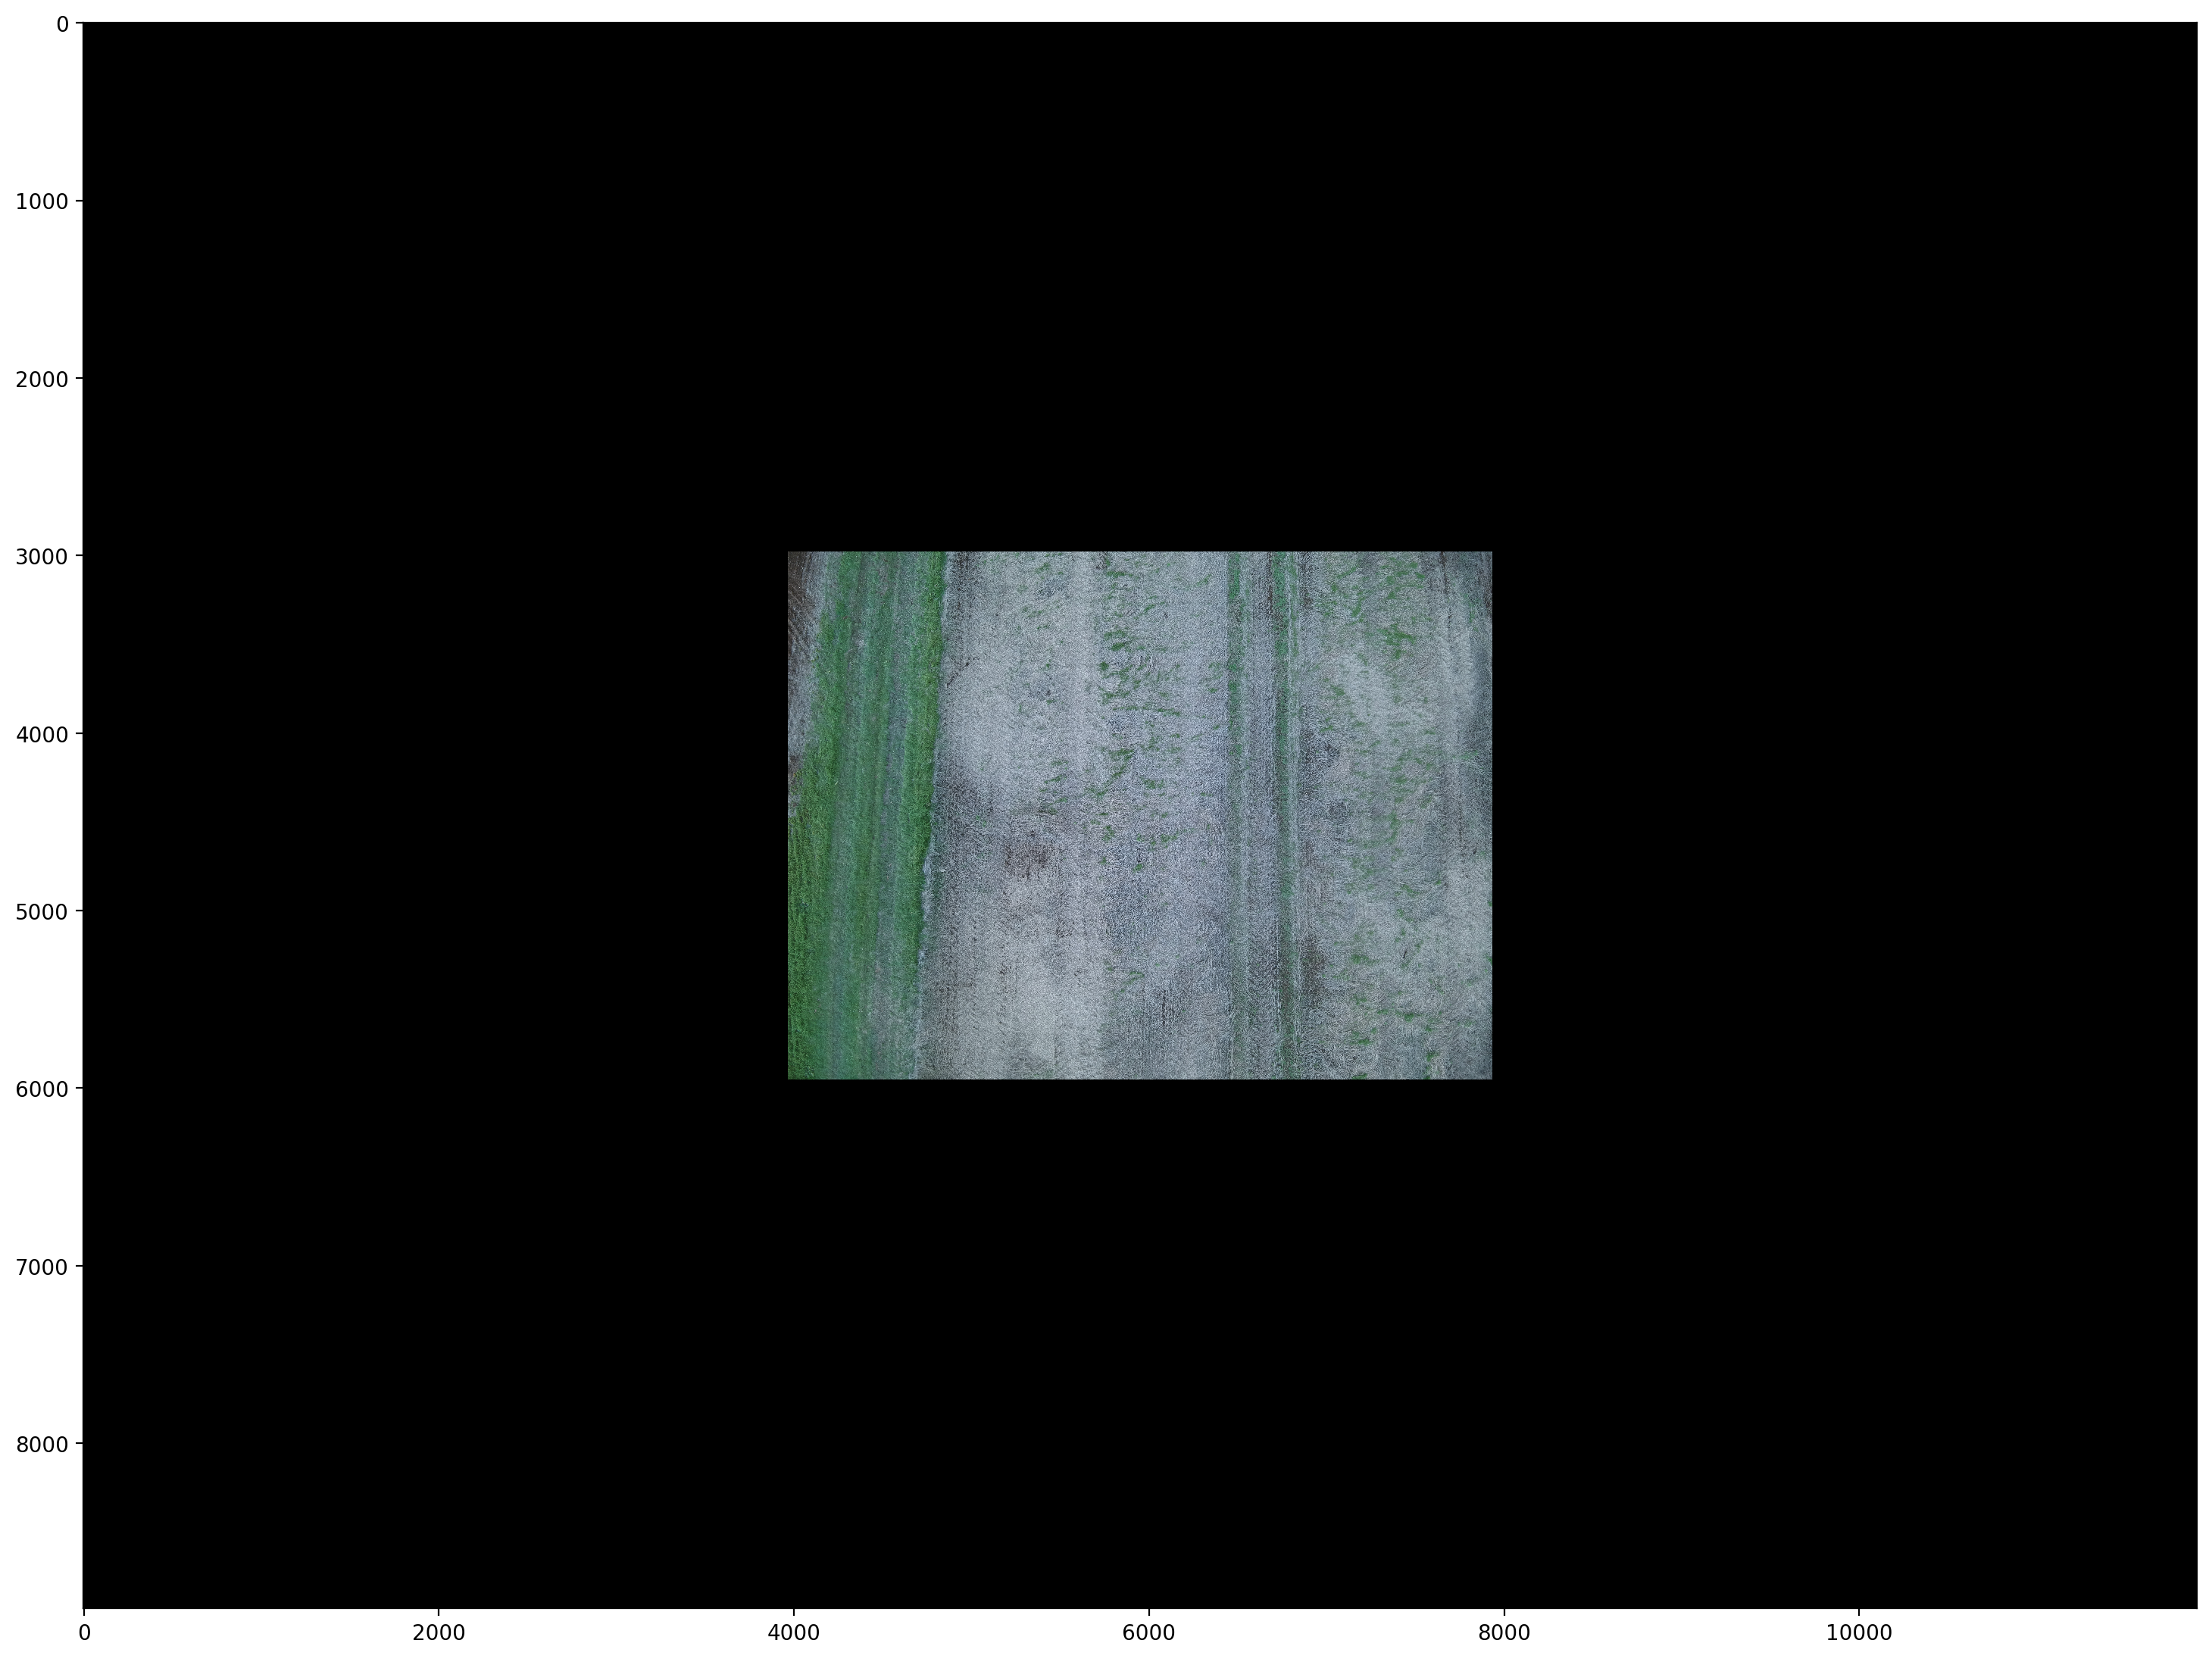

In [15]:
homography = find_homography(list_of_lists_of_images[0][0],list_of_lists_of_images[0][2])
resulting_image = putImagesTogether(list_of_lists_of_images[0][0],list_of_lists_of_images[0][2],homography)


fig=plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')  
cv2.imwrite('image.jpg',resulting_image)
plt.imshow(resulting_image)

In [8]:
def trim(frame):
    #crop top
    
    
    
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame



In [ ]:
 
trimmedimage=trim(g)

cv2.imwrite('drfghj.jpg',trimmedimage)